Preprocessing

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

In [ ]:
drive.mount('/content/gdrive/')
# Read the data
data_identification = pd.read_csv("/content/gdrive/MyDrive/gideon/data_identification.csv")
data_emotion = pd.read_csv("/content/gdrive/MyDrive/gideon/emotion.csv")

# Merge data_identification and data_emotion based on tweet id
merged_data = pd.merge(data_identification, data_emotion, on=['tweet_id'], how='left')
merged_data.rename(columns={'emotion':'label'}, inplace=True)
merged_data.head()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


,tweet_id,identification,label
0,0x28cc61,test,NaN
1,0x29e452,train,joy
2,0x2b3819,train,joy
3,0x2db41f,test,NaN
4,0x2a2acc,train,trust


In [ ]:
import json
import pandas as pd

# Specify the path to your JSON file
file_path = '/content/gdrive/MyDrive/gideon/tweets_DM.json'

# Initialize lists to store data
tweet_ids = []
texts = []

# Read the JSON data from the file
with open(file_path, 'r') as file:
    data_lines = file.readlines()

# Process each line
for line in data_lines:
    try:
        # Parse the JSON using a custom object hook
        data = json.loads(line, object_hook=lambda d: {k: v if not isinstance(v, list) or len(v) > 0 else None for k, v in d.items()})

        # Extract the required fields
        tweet_id = data.get('_source', {}).get('tweet', {}).get('tweet_id', None)
        text = data.get('_source', {}).get('tweet', {}).get('text', None)

        # Append data to lists
        tweet_ids.append(tweet_id)
        texts.append(text)
    except json.JSONDecodeError:
        # Handle invalid JSON entries
        print(f"Skipping invalid JSON entry: {line.strip()}")

# Create a Pandas DataFrame
df = pd.DataFrame({
    'tweet_id': tweet_ids,
    'text': texts
})

merged_data = pd.merge(merged_data, df, on=['tweet_id'], how='left')


In [ ]:
merged_data.head()

,tweet_id,identification,label,text
0,0x28cc61,test,NaN,@Habbo I've seen two separate colours of the e...
1,0x29e452,train,joy,Huge Respect🖒 @JohnnyVegasReal talking about l...
2,0x2b3819,train,joy,Yoooo we hit all our monthly goals with the ne...
3,0x2db41f,test,NaN,@FoxNews @KellyannePolls No serious self respe...
4,0x2a2acc,train,trust,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...


In [ ]:
merged_data.to_pickle("/content/gdrive/MyDrive/gideon/merged_data_distilBERT.pkl")

In [ ]:
drive.mount('/content/gdrive/')
# Read the data
merged_data = pd.read_pickle("/content/gdrive/MyDrive/gideon/merged_data_distilBERT.pkl")

Mounted at /content/gdrive/


In [ ]:
# Separate merged_data to training and test data
train_data = merged_data[merged_data['identification'] == 'train']
test_data = merged_data[merged_data['identification'] == 'test']
train_data.drop(['identification'], axis=1, inplace=True)
test_data.drop(['identification'], axis=1, inplace=True)

<ipython-input-3-901e6638b61a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['identification'], axis=1, inplace=True)
<ipython-input-3-901e6638b61a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['identification'], axis=1, inplace=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(train_data['label'])

train_data['label'] = numerical_labels

# To see the mapping between original labels and numerical values, you can use classes_ attribute
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


<ipython-input-4-c34153da2104>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = numerical_labels


In [ ]:
train_data.head()

,tweet_id,label,text
1,0x29e452,4,Huge Respect🖒 @JohnnyVegasReal talking about l...
2,0x2b3819,4,Yoooo we hit all our monthly goals with the ne...
4,0x2a2acc,7,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
5,0x2a8830,4,Come join @ambushman27 on #PUBG while he striv...
6,0x20b21d,1,@fanshixieen2014 Blessings!My #strength little...


Splitting dataset

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting train_data to train_data and val_data
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
# # Random undersampling
# from imblearn.under_sampling import RandomUnderSampler

# X_train = train_data.drop('label', axis=1)
# y_train = train_data['label']

# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# # Creating a new DataFrame with the resampled data
# resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

# # Display the resampled DataFrame
# print(resampled_data)

        tweet_id                                               text  label
0       0x242d34  Cant believe an older client claimed #MYPHOTOS...      0
1       0x1d7155  @foxfriendsfirst I am becoming racist!! sick o...      0
2       0x35dc4d  Literally just wasted 9$ on a car wash bc all ...      0
3       0x2ce684                        Took an L on that test <LH>      0
4       0x27ff00  @SamsungMobile @O2  free wireless charger offe...      0
...          ...                                                ...    ...
255219  0x374f26  #ItsAnUglyRealityBut we must accept what we ca...      7
255220  0x1d7743                  @DonnieWahlberg Always <LH> ❤❤❤❤❤      7
255221  0x293f1a        ##grateful for family life and friends.....      7
255222  0x29b9cd  @worldskillsuk @iansnedden @philDixon12 very w...      7
255223  0x2d41a7  We’ve got digital hugs, and plenty of thanks c...      7

[255224 rows x 3 columns]


In [ ]:
train_tweet_id = train_data['tweet_id']
val_tweet_id = val_data['tweet_id']
test_tweet_id = test_data['tweet_id']
train_data.drop(['tweet_id'], axis=1, inplace=True)
val_data.drop(['tweet_id'], axis=1, inplace=True)
test_data.drop(['tweet_id'], axis=1, inplace=True)

<ipython-input-6-51d9b64996f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['tweet_id'], axis=1, inplace=True)


In [ ]:
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20),
                    show_index=False,
                    pagination='local',
                         page_size=10)

pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

print('Dataset information:')
print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset information:
Training data: (1164450, 2)
Validation data: (291113, 2)
Test data: (411972, 2)


In [ ]:
train_data.dtypes

label     int64
text     object
dtype: object

Combine DataFrames into HuggingFace's Dataset

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

# Drop the index column if it's present
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
val_data['label'].fillna('-1', inplace=True)

# Don't forget the class label data
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'sadness', 'surprise', 'trust', 'joy']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets
emotions = DatasetDict({
    "train": Dataset.from_pandas(train_data,features=ft),
    "validation": Dataset.from_pandas(val_data,features=ft),
    "test": Dataset.from_pandas(test_data,features=ft)
    })

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1164450
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 291113
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 411972
    })
})

In [ ]:
# Training Data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 1164450
})

In [ ]:
# Convert Dataset to DataFrame (don't forget to reset)
emotions.set_format(type="pandas")
df = emotions["train"][:]
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

In [ ]:
# Add label data to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

Tokenization

In [ ]:
from transformers import AutoTokenizer

text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Show tokeniser information
tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')


Vocab size: 30522
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


In [ ]:
emotions.reset_format()

In [ ]:
# Tokenisation function
def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=100000)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/1164450 [00:00<?, ? examples/s]

Map:   0%|          | 0/291113 [00:00<?, ? examples/s]

Map:   0%|          | 0/411972 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


Training a text classifier

2. Fine-tuning transformers

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
# Load a pretrained model
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
from transformers import Trainer, TrainingArguments

num_labels = 8
# model_ckpt = "distilbert-base-uncased"
# model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

model_ckpt_path = "/content/gdrive/MyDrive/gideon/distilBERT/epoch2"  # Update with the path to your checkpoint
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt_path, num_labels=num_labels).to(device)


In [ ]:
# Defining the performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
bs = 64 # batch size
logging_steps = len(emotions_encoded["train"]) // bs
model_name = f"{model_ckpt_path}-finetuned-emotion-epoch3"

# training_args = TrainingArguments(output_dir=model_name,
#                                   logging_dir="./logs",
#                                   num_train_epochs=1,             # number of training epochs
#                                   learning_rate=2e-5,             # model learning rate
#                                   per_device_train_batch_size=bs, # batch size
#                                   per_device_eval_batch_size=bs,  # batch size
#                                   weight_decay=0.01,
#                                   evaluation_strategy="epoch",
#                                   disable_tqdm=False,
#                                   report_to="none",
#                                   logging_steps=logging_steps,
#                                   push_to_hub=False,
#                                   log_level="error")

training_args = TrainingArguments(output_dir="/content/gdrive/MyDrive/gideon/distilBERT",  # Update with your desired directory in Google Drive
                                  logging_dir="/content/gdrive/MyDrive/gideon/distilBERT/logs",  # Update with your desired directory in Google Drive
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=bs,
                                  per_device_eval_batch_size=bs,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error",
                                  save_total_limit=0)


In [ ]:
# Train model
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  # train_dataset = emotions_encoded["train"].select([i for i in range(int(len(emotions_encoded["train"]) * 0.001))]),
                  train_dataset = emotions_encoded["train"],
                  # eval_dataset=emotions_encoded["validation"].select([i for i in range(int(len(emotions_encoded["validation"]) * 0.001))]),
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.832800,0.954069,0.656941,0.647239


TrainOutput(global_step=18195, training_loss=0.8328044147142901, metrics={'train_runtime': 14460.7876, 'train_samples_per_second': 80.525, 'train_steps_per_second': 1.258, 'total_flos': 4.487349854016048e+16, 'train_loss': 0.8328044147142901, 'epoch': 1.0})

In [ ]:
trainer.save_model("/content/gdrive/MyDrive/gideon/distilBERT/epoch3")

In [ ]:
# Predict on validation dataset
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output

In [ ]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions,axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

In [ ]:
# Show metrics of last iteration
pred_output.metrics

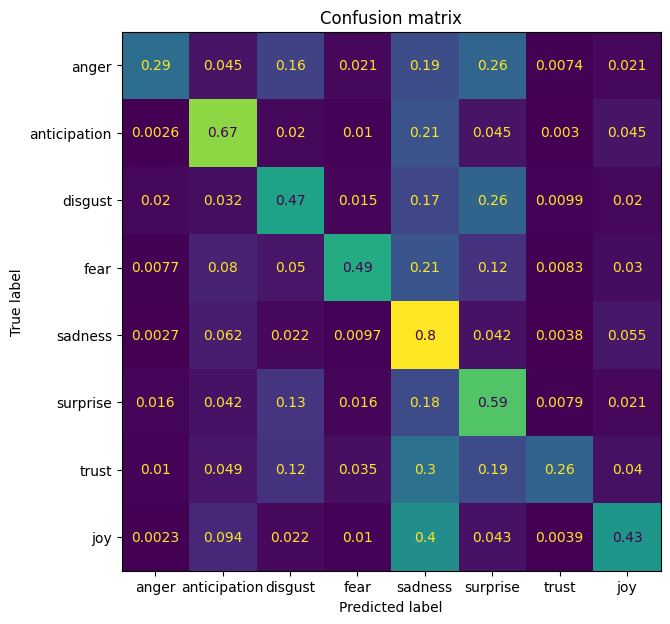

In [ ]:
y_valid = np.array(emotions_encoded["validation"]["label"])
labels = emotions_encoded["train"].features["label"].names

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds,y_valid, labels)

Model Error Analysis

In [ ]:
# Loss value mapping
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):

    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True,
                                                                    batch_size=16)

Map:   0%|          | 0/291113 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [ ]:
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

In [ ]:
show_panel(df_test.sort_values("loss", ascending=True))

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

Predict test data

In [ ]:
# Save the model
trainer.save_model()

In [ ]:
emotions_encoded["test"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 411972
})

In [ ]:
len(emotions_encoded["test"]["text"])

411972

In [ ]:
from transformers import pipeline

# load from previously saved model
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# Predict test data
preds = classifier(emotions_encoded["test"]["text"])
preds

KeyboardInterrupt: ignored

In [ ]:
# Extract only the label numbers
y_preds = [int(prediction['label'].split('_')[1]) for prediction in preds]

class_mapping = {0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear',
                 4: 'sadness', 5: 'surprise', 6: 'trust', 7: 'joy'}
# Convert list of numbers to list of class names
y_preds = [class_mapping[pred] for pred in y_preds]

# Create submission dataframe
sub_df = pd.DataFrame({'tweet_id': test_tweet_id, 'prediction': y_preds})

In [ ]:
# Rename the columns
sub_df.rename(columns={'tweet_id':'id', 'prediction':'emotion'}, inplace=True)
# Reset the index, removing the current index
sub_df = sub_df.reset_index(drop=True)

In [ ]:
# Convert submission dataframe to csv
sub_df.to_csv("/content/gdrive/MyDrive/gideon/submission_3.csv", index=False)

NameError: ignored